<a href="https://colab.research.google.com/github/harpreetsodhi/ChangeMyPet_Deep_Learning_Model/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [3]:
# model2 = torch.hub.load('pytorch/vision:v0.6.0', 'fcn_resnet101', pretrained=True).eval()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
!git clone "https://github.com/harpreetsodhi/ChangeMyPet_Deep_Learning_Model.git"

Cloning into 'ChangeMyPet_Deep_Learning_Model'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 94 (delta 32), reused 45 (delta 8), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [23]:
# sample execution (requires torchvision)
from PIL import Image, ImageOps
from torchvision import transforms

input_image = Image.open('/content/dog_translate.png')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    # model2.to('cuda')
# ouput_original_image = output.argmax(0).float()

In [16]:
from ChangeMyPet_Deep_Learning_Model.src.biggan import BigGAN256
import torch 
import torchvision
from scipy.stats import truncnorm
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [34]:
truncation = torch.clamp(torch.tensor(0.4), min=0.02+1e-4, max=1.0-1e-4).float()  # truncation is 0.4
c = torch.tensor((207,)).long()  # class_label is 260
# z = truncation * torch.as_tensor(truncnorm.rvs(-2.0, 2.0, size=(1, 140),random_state=18)).float()
z = truncation * torch.as_tensor(truncnorm.rvs(-2.0, 2.0, size=(1, 140))).float()
z.requires_grad = True

biggan = BigGAN256()

biggan.load_state_dict(torch.load("/content/drive/My Drive/BigGAN/biggan256-release.pt"))

<All keys matched successfully>

In [ ]:
def softXEnt (input, target ):
    logprobs = torch.nn.functional.log_softmax (input, dim = 0)
    return  -(target * logprobs).sum() / (input.shape[1]*input.shape[2])

In [19]:
def MSE_Loss (input, target):
  loss = torch.nn.MSELoss()
  return loss(input, target)

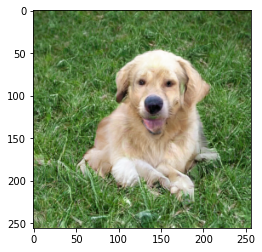

In [22]:
biggan.eval()
img = biggan(z, c, truncation.item())
pil = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())
import PIL
# pil=ImageOps.mirror(pil)
# pil=pil.transpose(PIL.Image.ROTATE_90)
plt.imshow(pil)
pil.save("dog_translate.png")

Epoch :  1
Loss  :  0.11363515257835388


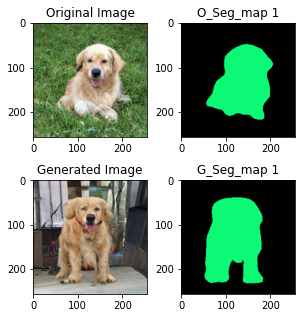

----------------------------------------------------------------------------------------------------
Epoch :  2
Loss  :  0.07577861100435257


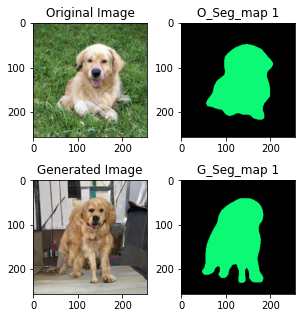

----------------------------------------------------------------------------------------------------


KeyboardInterrupt: ignored

In [35]:
biggan.eval()
# optimizer = torch.optim.AdamW([z], lr=0.1)
optimizer = torch.optim.Adam([z], lr=1e-1, betas=(0.5, 0.999))

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

mean1 = [0.485, 0.456, 0.406]
std1 = [0.229, 0.224, 0.225]

for i in range(10):
    with torch.enable_grad():
        optimizer.zero_grad()
        img = biggan(z, c, truncation.item())

        # preprocessing of the generated image
        img = 0.5 * (img + 1)
        # img[0][0] = (img[0][0] - mean1[0])/std1[0]
        # img[0][1] = (img[0][1] - mean1[1])/std1[1]
        # img[0][2] = (img[0][2] - mean1[2])/std1[2]
        
        #Segmentation of Predicted Img
        # output_predicted_image_1 = model(0.5 * (img.cuda() + 1))['out'][0]
        # output_predicted_image_2 = model2(0.5 * (img.cuda() + 1))['out'][0]
        output_predicted_image_1 = model(img.cuda())['out'][0]
        
        #applying softmax on predicted imgs segmaps
        output_predicted_image_1_s = torch.nn.functional.softmax (output_predicted_image_1, dim = 0) #softmax o_P1
        # output_predicted_image_2_s = torch.nn.functional.softmax (output_predicted_image_2, dim = 0) #softmax o_P2
        
        #take average of 2 predicted img segmaps
        # output_p = (output_predicted_image_1_s + output_predicted_image_2_s)/2  # softmax_predicted_output_average
        
        #Segmentation of Original Img
        output_original_image_1 = model(input_batch)['out'][0]
        # output_original_image_2 = model2(input_batch)['out'][0]
        
        #applying softmax on original imgs segmaps
        output_original_image_1_s=torch.nn.functional.softmax (output_original_image_1, dim = 0) #softmax o_o_1
        # output_original_image_2_s=torch.nn.functional.softmax (output_original_image_2, dim = 0) #softmax o_o_2
        
        #take average of 2 original img segmaps
        # output_o = (output_original_image_1_s + output_original_image_2_s)/2 # softmax_original_output_average
        # output_o = output_o[12]

        # Target image segmaps
        # target = torch.nn.functional.softmax (output_o[[0,12]], dim = 0) # softmax on the target 
        # target = output_o[12]
        target = output_original_image_1_s[12]

        # seg_1 = torch.nn.functional.softmax (output_predicted_image_1_s[[12]], dim = 0) # softmax on the target 
        # seg_2 = torch.nn.functional.softmax (output_predicted_image_2_s[[12]], dim = 0) # softmax on the target 
        seg_1 = output_predicted_image_1_s[12]
        # seg_2 = output_predicted_image_2_s[12]

        # loss1 = MSE_Loss(seg_1, target)
        # loss2 = MSE_Loss(seg_1, target)
        cost_x = MSE_Loss(seg_1, target)

        # cost_x = (loss1 + loss2 ) / 2 

        print("Epoch : ",i+1)
        print("Loss  : ", cost_x.item())


    fig = plt.figure(figsize=(10,5))
    plt.subplots_adjust(left = 0.125,right = 0.9,top=0.9,bottom = 0.1,wspace = 0.3,hspace = 0.2)

    ax1 = fig.add_subplot(241)
    ax1.title.set_text('Original Image')
    plt.imshow(input_image)

    ax2 = fig.add_subplot(242)
    ax2.title.set_text('O_Seg_map 1')
    r = Image.fromarray(model(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    r.putpalette(colors)
    plt.imshow(r)
     
    # ax3 = fig.add_subplot(243)
    # ax3.title.set_text('O_Seg_Map 2')
    # r = Image.fromarray(model2(input_batch)['out'][0].argmax(0).float().byte().cpu().numpy())#.resize(input_image.size)
    # r.putpalette(colors)
    # plt.imshow(r)

    # ax4 = fig.add_subplot(244)
    # ax4.title.set_text('O_Avg Seg_Map')
    # r = Image.fromarray(output_o.argmax(0).float().byte().cpu().numpy())
    # r.putpalette(colors)
    # plt.imshow(r)

    ax5 = fig.add_subplot(245)
    ax5.title.set_text('Generated Image')
    # pil = torchvision.transforms.ToPILImage()((0.5 * (img.data + 1)).squeeze())
    pil = torchvision.transforms.ToPILImage()(img.data.squeeze())
    plt.imshow(pil)

    ax6 = fig.add_subplot(246)
    ax6.title.set_text('G_Seg_map 1')
    r = Image.fromarray(output_predicted_image_1.argmax(0).float().byte().cpu().numpy())
    r.putpalette(colors)
    plt.imshow(r)

    # ax7 = fig.add_subplot(247)
    # ax7.title.set_text('G_Seg_Map 2')
    # r = Image.fromarray(output_predicted_image_2.argmax(0).float().byte().cpu().numpy())
    # r.putpalette(colors)
    # plt.imshow(r)

 
    # ax8 = fig.add_subplot(248)
    # ax8.title.set_text('G_Avg Seg_Map')
    # r = Image.fromarray(output_p.argmax(0).float().byte().cpu().numpy())
    # r.putpalette(colors)
    # plt.imshow(r)
    plt.show()

    print('-'*100)
    cost_x.backward()
    optimizer.step()

print('End')

In [37]:
img.shape

torch.Size([1, 3, 256, 256])

In [40]:
img.min()

tensor(0.0085, grad_fn=<MinBackward1>)